In [1]:
# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.patches as mpatches
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# import pandas & numpy library
import pandas as pd
import numpy as np

# Statmodels & patsy
import patsy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

import re
import csv

# **Clean Data**

Drop/rename and create columns

In [2]:
data = pd.read_csv('164_data.csv')

# Drop and rename columns
data = data.drop(labels = ['EndDate', 'SC0', 'SC3', 'Duration (in seconds)', 'Status', 'IPAddress', 'Progress', 
        'Finished', 'RecordedDate', 'ResponseId',
        'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
        'ExternalReference', 'LocationLatitude', 'LocationLongitude',
        'DistributionChannel', 'UserLanguage', 'Q9',
        'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q20',
        'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29',
        'Q32_1', 'Q32_2', 'Q32_3',
        'Q32_4', 'Q32_5', 'Q32_6', 'Q32_7', 'Q32_8', 'Q32_9', 'Q32_10',
        'Q32_11', 'Q32_12', 'Q32_13', 'Q32_14', 'Q32_15', 'Q32_16'], axis=1)

data.columns = ['StartDate', 'Q_Eat', 'Q_Sleep', 'Q_Comfort', 'Q_Exercise',
       'C_First Click', 'C_Last Click', 'C_PageSubmit',
       'C_Click Count', 'E_First Click', 'E_Last Click',
       'E_PageSubmit', 'E_Click Count',
       'Q_Age', 'Q_Gender', 'Q_Ethn', 'Q_Income', 'Q_FinSec', 'PSS',
       'Worry', 'IM', 'IR', 'ER', 'AM', 'KeyResponses', 'PlayerScore']

data = data.iloc[1:]

# Add column describing experimental/control group
data = data.assign(Group= data['C_PageSubmit'].isna().apply(lambda x: 'Experimental' if x == True else 'Control'))

In [3]:
# Combine column repeats
def combine_CE(data):
    CE_cols = np.unique([col[1] for col in data.columns.str.split('_') if col[0] in ['C', 'E']])
    for label in CE_cols:
        C_col = f"C_{label}"
        E_col = f"E_{label}"
        if C_col in data.columns and E_col in data.columns:
            data = data.assign(**{label: data[C_col].fillna(data[E_col])})
            data = data.drop(labels= [C_col, E_col], axis=1)

    return data

data = combine_CE(data)

Extract demographic information since it's not being included in any analysis

In [4]:
# Split data into data for analysis and demographic information
demographic_info = data[['Q_Age', 'Q_Gender', 'Q_Ethn', 'Q_Income', 'Q_FinSec']]
data = data[data.columns.difference(['Q_Age', 'Q_Gender', 'Q_Ethn', 'Q_Income', 'Q_FinSec'])].drop(labels= ['First Click', 'Last Click'], axis=1)

Covert numeric columns to floats, add SDI column, and reorder columns/add multi-index

In [5]:
# Convert numeric columns to floats for handling
def float_convert(value):
    try:
        return float(value)
    except:
        return np.nan

num_cols = ['PSS', 'Worry', 'IM', 'IR', 'ER', 'AM', 'PlayerScore', 'PageSubmit']
for col in num_cols:
    data[col] = data[col].apply(float_convert)

In [6]:
# Add column for self-determination scale based on the formula
data = data.assign(SDI= 2*data["IM"]+data["IR"]-data["ER"]-2*data["AM"])

In [7]:
# Reorder columns for salience and create multi-index
data = data[['StartDate', 'Group', 'PageSubmit', 'PlayerScore', 'Worry', 'PSS', 'SDI', 'IM', 'IR', 'ER', 'AM',
       'Q_Comfort', 'Q_Eat', 'Q_Exercise', 'Q_Sleep', 'Click Count', 'KeyResponses']]

multi_index = [
    ('Metadata', 'StartDate'),
    ('Metadata', 'Group'),
    ('Task', 'PageSubmit'),
    ('Task', 'PlayerScore'),
    ('Psych', 'Worry'),
    ('Psych', 'PSS'),
    ('SIMS', 'SDI'),
    ('SIMS', 'IM'),
    ('SIMS', 'IR'),
    ('SIMS', 'ER'),
    ('SIMS', 'AM'),
    ('Questions', 'Comfort'),
    ('Questions', 'Ate'),
    ('Questions', 'Exercise'),
    ('Questions', 'Sleep'),
    ('Interactions', 'Click Count'),
    ('Interactions', 'KeyResponses')
]

# Assign MultiIndex to DataFrame columns
data.columns = pd.MultiIndex.from_tuples(multi_index)

In [8]:
# Remove rows will null values
data = data[data[['Task', 'Psych', 'SIMS']].isna().any(axis=1) == False]

Convert body state information to make it more readable

In [9]:
# Function for coverting comfort column into numeric values (Scale: -2 --> 2)
def convert_comfort(input):
    output = 0
    if "Very" in input:
        output = 2
    elif "Somewhat" in input:
        output = 1
    else:
        output = 0
    
    if "uncomfortable" in input:
        output *= -1
    
    return str(output)

In [10]:
# Function for coverting sleep and eat columns
def convert_hrs(input):
    output = input.replace('hours', 'hrs')
    output = output.replace('< ', '0-')
    output = output.replace('≤ ', '0-')
    output = output.replace('≥ ', '')
    if '8 ' in output and '6' not in output:
        output = output.replace('8', '8+')
    
    return output

In [11]:
# Apply conversions to Questions
data['Questions'] = data['Questions'].assign(Comfort= data['Questions', 'Comfort'].map(convert_comfort), 
                    Ate= data['Questions', 'Ate'].map(convert_hrs),
                    Sleep= data['Questions', 'Sleep'].map(convert_hrs))
data['Questions', 'Exercise'] = data['Questions', 'Exercise'].apply(lambda str: str.replace('days per week', 'd/wk'))

In [12]:
# Data after cleaning
data.head()

Metadata                Task             Psych        SIMS        \
       StartDate    Group PageSubmit PlayerScore Worry   PSS   SDI    IM   
5  3/10/25 22:06  Control   1503.299         0.0  31.0  25.0 -21.0  13.0   
6  3/12/25 13:39  Control    659.619       650.0  40.0  20.0  27.0  19.0   
7  3/14/25 12:11  Control    632.779       550.0  18.0   8.0  54.0  28.0   
8  3/12/25 18:06  Control    626.674         0.0  39.0  17.0  18.0  16.0   
9  3/12/25 00:17  Control    626.140      1000.0  45.0  18.0  72.0  28.0   

                    Questions                                         \
     IR    ER    AM   Comfort          Ate         Exercise    Sleep   
5  10.0   7.0  25.0         1  0-2 hrs ago  3-5 days a week  5-7 hrs   
6  19.0  22.0   4.0         0  0-2 hrs ago  3-5 days a week  5-7 hrs   
7  16.0  10.0   4.0         2   8+ hrs ago  1-2 days a week  0-2 hrs   
8  16.0  16.0   7.0         1  0-2 hrs ago  6-7 days a week  5-7 hrs   
9  28.0   4.0   4.0         1  0-2 hrs ago  3-5 days a week  5-7 hrs   

  Interactions               
   Click Count KeyResponses  
5            0            i  
6            0          NaN  
7            1          NaN  
8           48            u  
9            0          NaN

**Separate data into two data frames:** Control and Experimental
- *(makes some functions easier, but these dataframes will not always be used)*

In [13]:
# Create two dataframes: separate data from each group
E_data = data[data['Metadata','Group'] == 'Experimental']
C_data = data[data['Metadata','Group'] == 'Control']

# **Plotting**

### Distributions of numeric variables

*For measures that are taken before the task commences (PSS and Worry), these distributions should look relatively simiar between groups.
All other distributions might be affected by group*

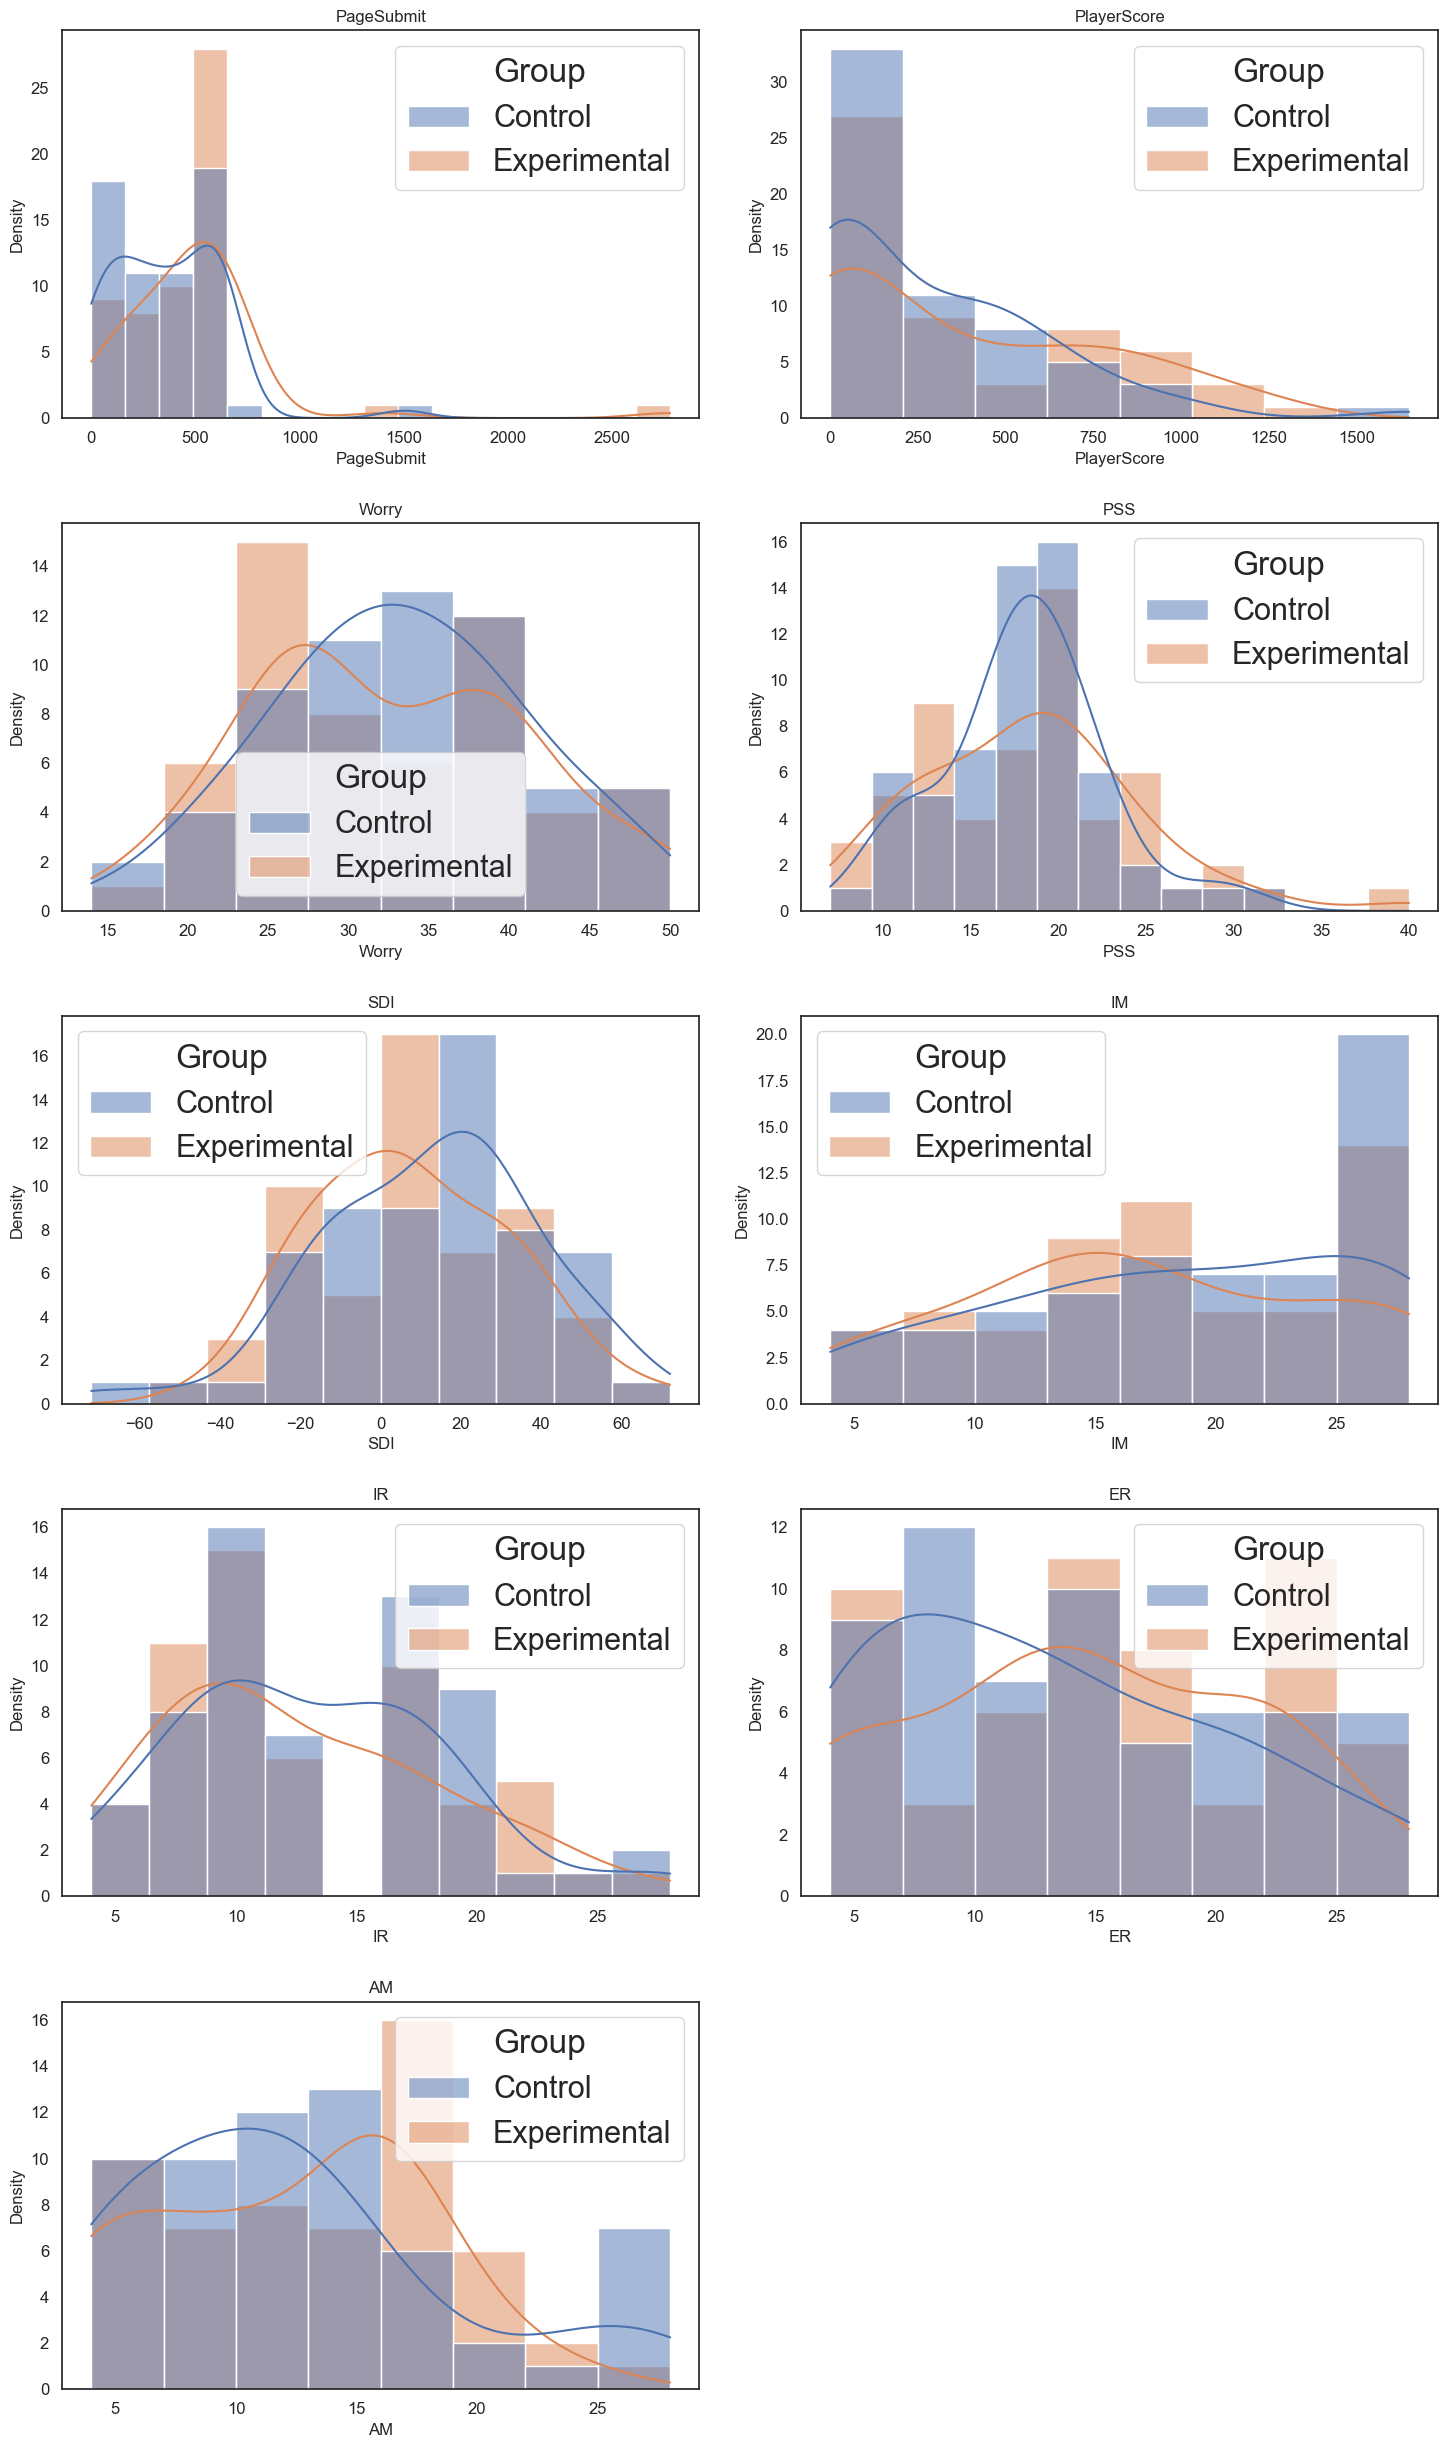

In [14]:
# Plot distributions of all numeric variables between groups
def btwn_groups_plots(data, subplots, fig_size):
    v, h = subplots[:2]
    fig, axes = plt.subplots(v, h, figsize=fig_size)
    label_size =12
    i = 0

    if v * h == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Use second level of multi-index to index columns for plotting
    data2 = data.droplevel(level=0, axis=1)

    # Only plot numeric columns
    for col in data[['Task', 'Psych', 'SIMS']].columns.get_level_values(1):
        sns.histplot(data= data2, x= col, ax=axes[i], hue= 'Group', kde= True, common_norm= True)
        axes[i].set_title(col, fontsize=label_size)
        axes[i].set_xlabel(col, fontsize=label_size)
        axes[i].set_ylabel('Density', fontsize=label_size)
        axes[i].tick_params(axis="both", labelsize=label_size)
        i += 1

    fig.delaxes(axes[-1])
    plt.tight_layout()

btwn_groups_plots(data, [len(num_cols)//2+1, 2, 1], [15, 25])

## Scatterplots of numeric variables vs. PlayerScore and PageSubmit (quitting time)

In [15]:
# Functions relationships of all numeric variable to task score and quitting time
def within_groups_plots(data, subplots, fig_size):
    v, h = subplots[:2]
    fig, axes = plt.subplots(v, h, figsize=fig_size)
    label_size = 9
    i = 0

    if v * h == 1:
        axes = [axes]  # Convert single-axis to a list
    else:
        axes = axes.flatten()

    data2 = data.droplevel(level=0, axis=1)
    for y_col in data['Task'].columns:
        for x_col in data[['Psych', 'SIMS']].columns.get_level_values(1):
            sns.scatterplot(data= data2, x= x_col, y= y_col, hue= "Group", ax=axes[i])
            axes[i].set_title(f"{y_col} vs. {x_col}", fontsize=label_size)
            axes[i].set_xlabel(x_col, fontsize=label_size)
            axes[i].set_ylabel(y_col, fontsize=label_size)
            axes[i].tick_params(axis="both", labelsize=label_size)
            axes[i].legend(fontsize= label_size)
            i += 1

    if len(subplots) == 3:
        extra_axes = v * h - i
        for j in range(extra_axes):
            plt.delaxes(axes[i + j])
            
    plt.tight_layout()

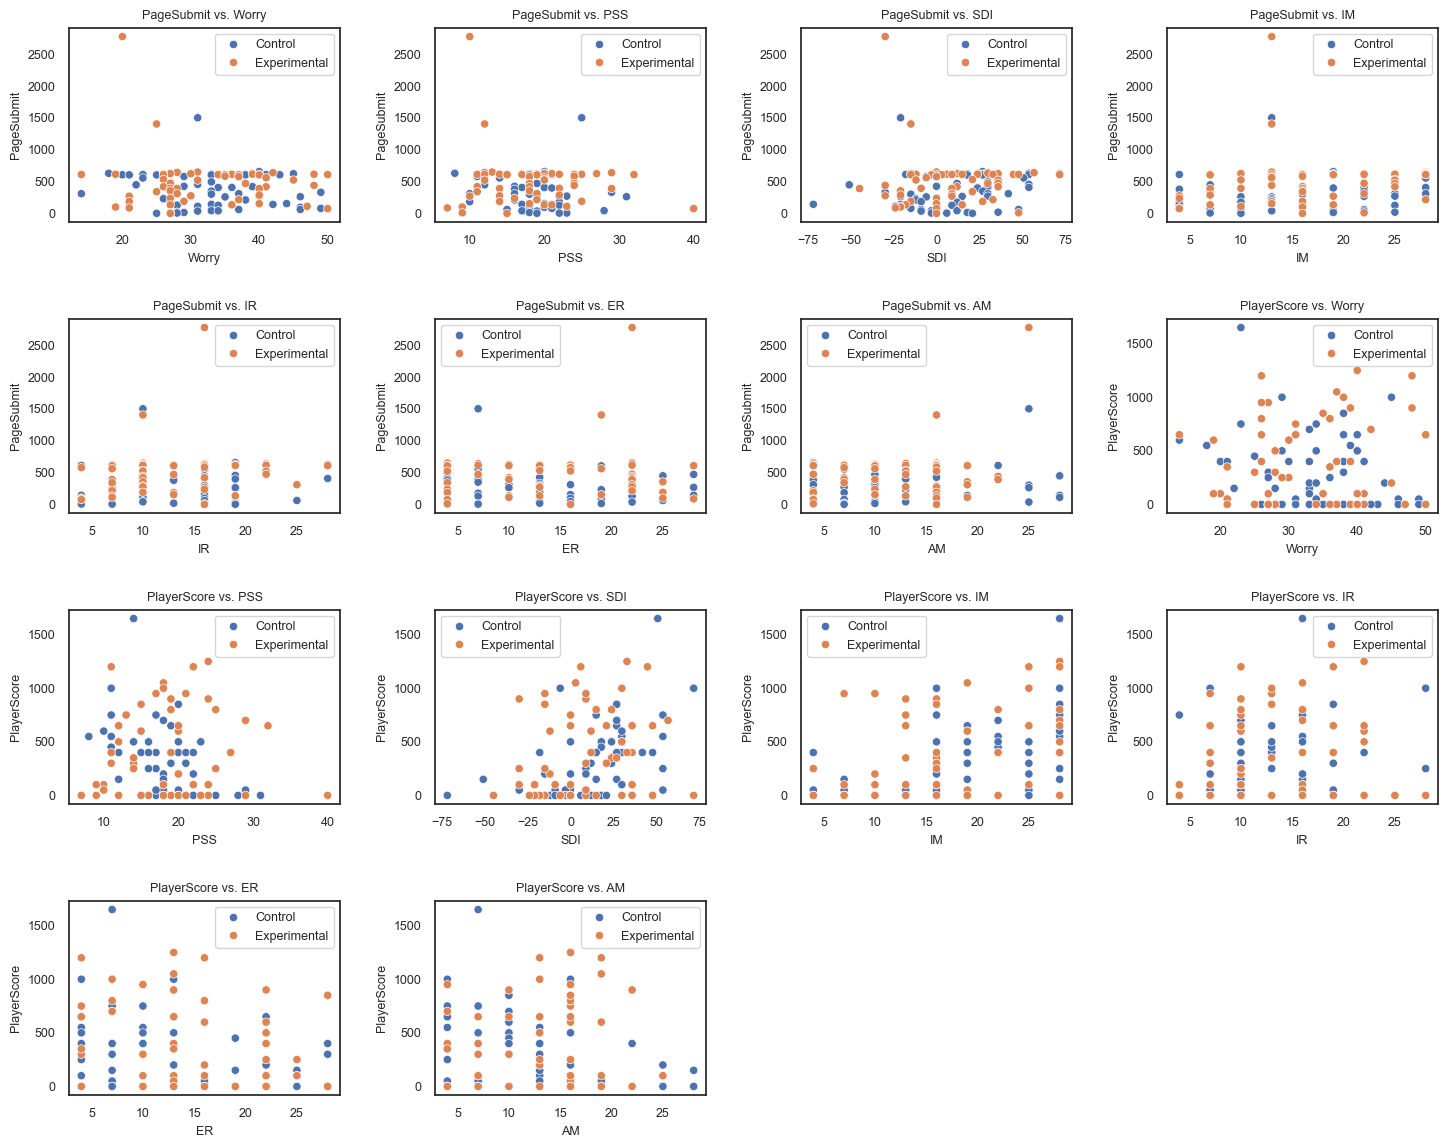

In [16]:
# Plot experimental group data
within_groups_plots(data, [4, 4, 1], [15, 12])

## Score/Quitting Time Distribution Boxplots

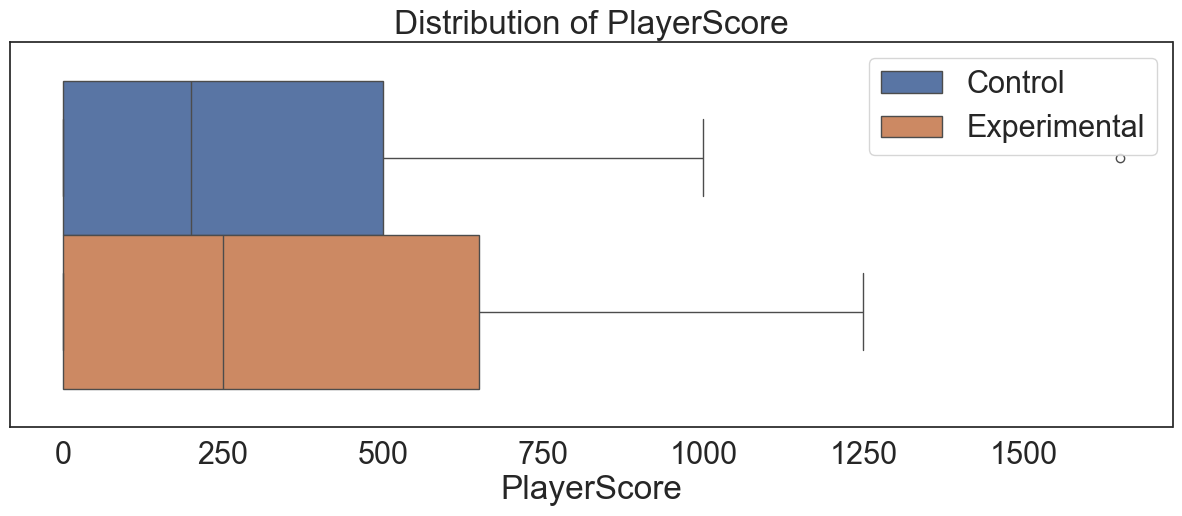

In [17]:
# Plot distributions of player score between groups
plt.figure(figsize= (15,5))
sns.boxplot(data=data.droplevel(level=0, axis=1), x="PlayerScore", hue="Group")
plt.title("Distribution of PlayerScore")
plt.legend(loc= "upper right")

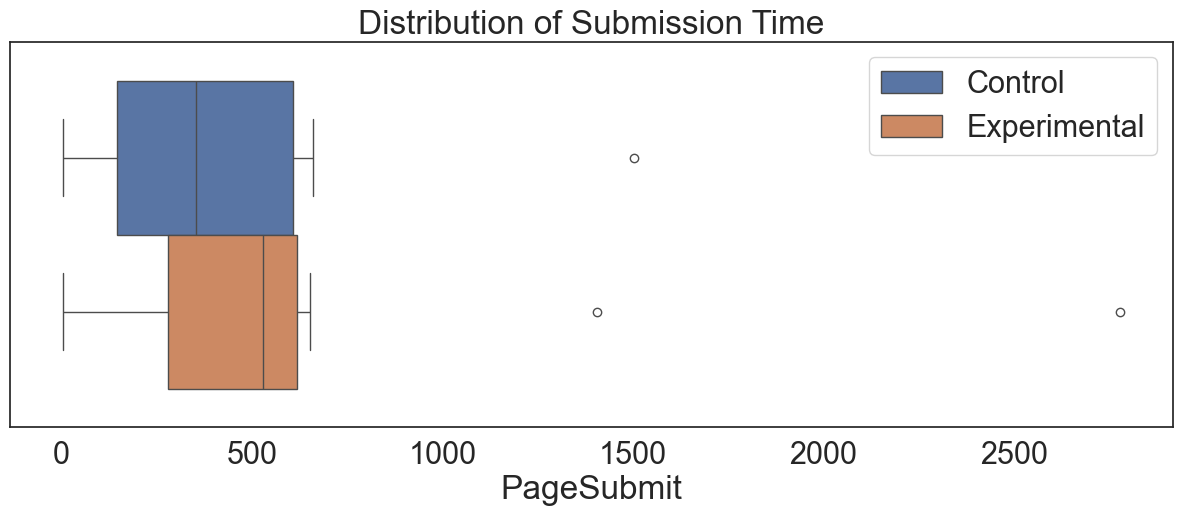

In [18]:
# Plot distributions of quitting time between groups
plt.figure(figsize= (15,5))
sns.boxplot(data=data.droplevel(level=0, axis=1), x="PageSubmit", hue="Group")
plt.title("Distribution of Submission Time")
plt.legend(loc= "upper right")

# **Spearman's Coefficients and Correlations**

Spearman's Rank Correlation Coefficients: describe the correlation of numeric variables to score and quitting time

In [19]:
# Calculate spearman correlations between variables
spearman_E = E_data[['Task', 'Psych', 'SIMS']].droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]
spearman_C = C_data[['Task', 'Psych', 'SIMS']].droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]

Experimental group correlations

In [20]:
# Spearman's correlations for the experiemental group
spearman_E

,PageSubmit,PlayerScore
Worry,0.050487,0.022989
PSS,0.076219,0.025072
SDI,0.240730,0.252655
IM,0.350126,0.369931
IR,0.267058,0.190226
ER,-0.046744,-0.123967
AM,0.118465,0.168910


Control group correlations

In [21]:
# Spearman's correlations for the control group
spearman_C

,PageSubmit,PlayerScore
Worry,0.049343,-0.081293
PSS,-0.280715,-0.356723
SDI,0.378600,0.498016
IM,0.428981,0.523624
IR,0.133919,0.160351
ER,-0.251213,-0.173449
AM,-0.068871,-0.198897


## Plot correlation coefficients to visualize which variables are most correlated to score/quitting time

Correlation plot for quitting time

Text(0.5, 0, 'Survey Score')

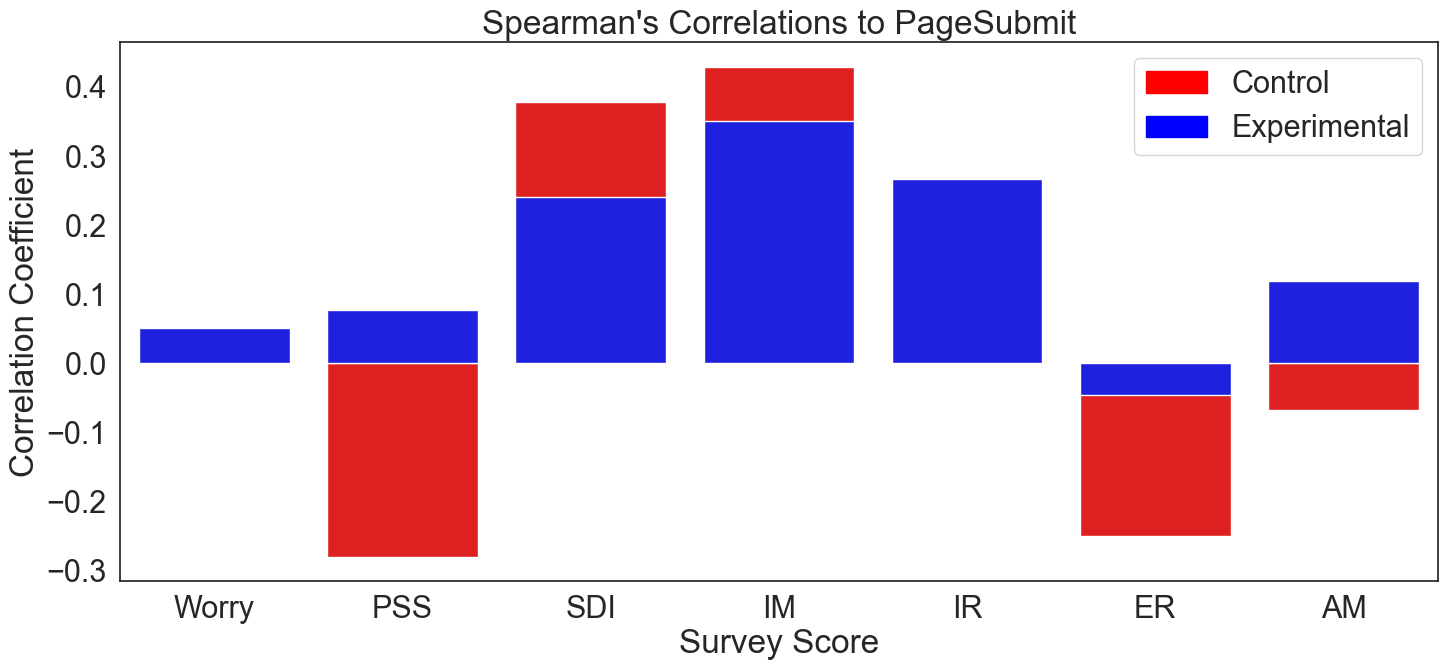

In [22]:
# Plot correlations to quitting time of all survey results
C_bar = sns.barplot(data= spearman_C["PageSubmit"], color= 'red')
C_patch = mpatches.Patch(color='red', label='Control')
E_bar = sns.barplot(data= spearman_E["PageSubmit"], color= 'blue')
E_patch = mpatches.Patch(color='blue', label='Experimental')
plt.legend(handles= [C_patch, E_patch])
plt.title("Spearman's Correlations to PageSubmit")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Survey Score")

Correlation plot for score

Text(0.5, 0, 'Survey Score')

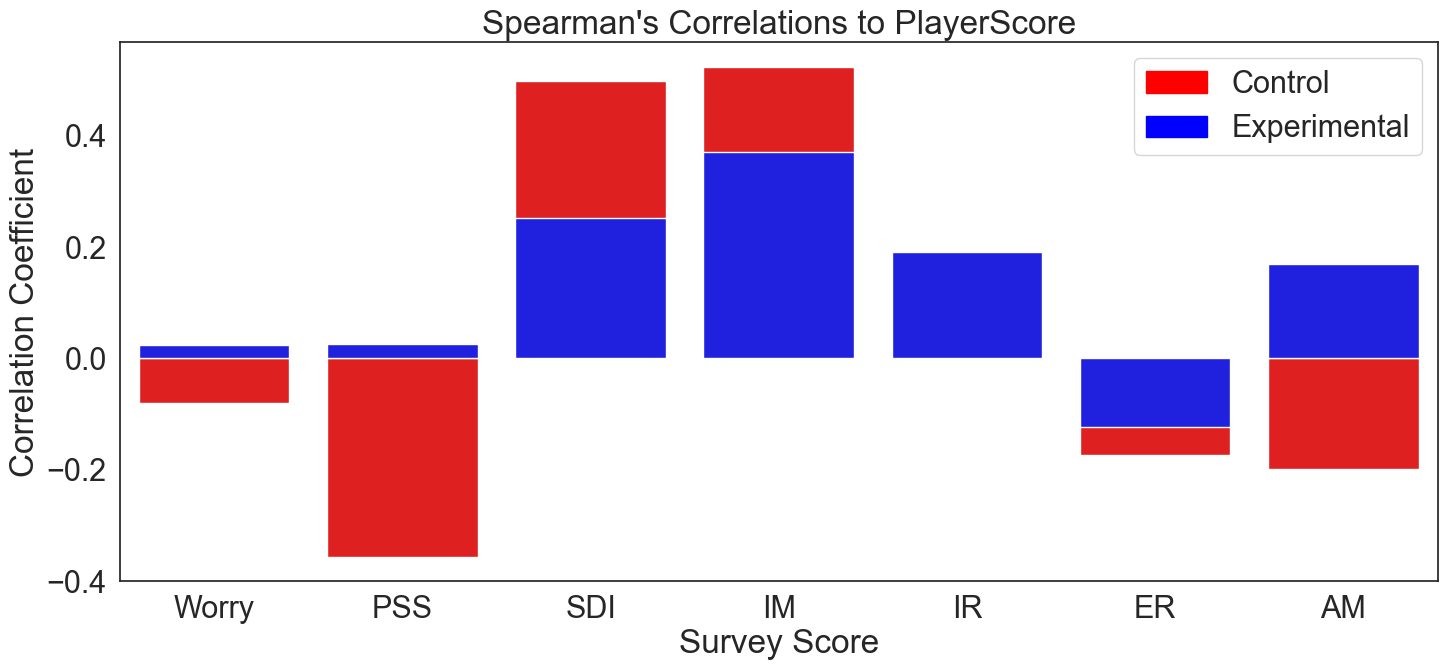

In [23]:
# Plot correlations to score of all survey results
C_bar = sns.barplot(data= spearman_C["PlayerScore"], color= 'red')
C_patch = mpatches.Patch(color='red', label='Control')
E_bar = sns.barplot(data= spearman_E["PlayerScore"], color= 'blue')
E_patch = mpatches.Patch(color='blue', label='Experimental')
plt.legend(handles= [C_patch, E_patch])
plt.title("Spearman's Correlations to PlayerScore")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Survey Score")

## P-values for correlations

In [24]:
# Create function to get p-values
def get_pval(data, degrees_of_freedom, tails= "two-sided"):
    tstat_df = data.apply(lambda r: r * np.sqrt(len(C_data) - 2) / np.sqrt(1 - r**2))
    if tails == "one-sided":
        pval_df = tstat_df.apply(lambda t: stats.t.cdf(t, degrees_of_freedom))
    elif tails == "two-sided":
        pval_df = tstat_df.apply(lambda t: 2 * (1 - stats.t.cdf(abs(t), degrees_of_freedom)))
    else:
        raise ValueError("tails must be defined")
    
    return pval_df

In [25]:
# Call get_pval function to create dataframes for the experiemental (E) and control (C) groups with significance of correlations
C_pvalues_df = get_pval(spearman_C, len(C_data)-1)
E_pvalues_df = get_pval(spearman_E, len(E_data)-1)

p-values for the control group

In [26]:
# Look at p-values for control
C_pvalues_df

,PageSubmit,PlayerScore
Worry,0.705675,0.533367
PSS,0.028362,0.004748
SDI,0.002606,0.000043
IM,0.000555,0.000015
IR,0.303433,0.216943
ER,0.050755,0.181197
AM,0.597882,0.124279


p-values for the experimental group

In [27]:
# Look at p-values for experimental
E_pvalues_df

,PageSubmit,PlayerScore
Worry,0.699269,0.860436
PSS,0.559460,0.847938
SDI,0.061906,0.049723
IM,0.005764,0.003409
IR,0.037698,0.142275
ER,0.720618,0.341376
AM,0.363386,0.193424


**Which p-values are significant for each group?**

In [28]:
# Function for printing which p-values are significant
def significant_pval(data, group):
    output = f"{group}: Significant P-values\n\n"
    threshold = 0.05
    sig_data = data.apply(lambda p: p <= threshold)
    for row in data.index:
        for col in data.columns:
            if sig_data.loc[row, col] == True:
                output += f"{row} vs. {col}:\t P-value: {data.loc[row, col]:10f}\n"
    return output

In [29]:
print(significant_pval(C_pvalues_df, "Control"))

Control: Significant P-values

PSS vs. PageSubmit:	 P-value:   0.028362
PSS vs. PlayerScore:	 P-value:   0.004748
SDI vs. PageSubmit:	 P-value:   0.002606
SDI vs. PlayerScore:	 P-value:   0.000043
IM vs. PageSubmit:	 P-value:   0.000555
IM vs. PlayerScore:	 P-value:   0.000015



In [30]:
print(significant_pval(E_pvalues_df, "Experimental"))

Experimental: Significant P-values

SDI vs. PlayerScore:	 P-value:   0.049723
IM vs. PageSubmit:	 P-value:   0.005764
IM vs. PlayerScore:	 P-value:   0.003409
IR vs. PageSubmit:	 P-value:   0.037698



# Mann-Whitney U Tests 
Testing significance of differences between groups

In [31]:
# Mann-Whitney U Tests for PlayerScore -- H1 : E > C
score_u_stat, score_pval = stats.mannwhitneyu(np.array(E_data['Task', 'PlayerScore']), 
                                     np.array(C_data['Task', 'PlayerScore']), 
                                     method='exact', alternative='greater')
print(f"The p-value for the distribution of score between groups given H1 : E > C is\t{score_pval}")

The p-value for the distribution of score between groups given H1 : E > C is	0.14009061900246386


In [32]:
# Mann-Whitney U Tests for PageSubmit -- H1 : E > C
submit_u_stat, submit_pval = stats.mannwhitneyu(np.array(E_data['Task', 'PageSubmit']), 
                                     np.array(C_data['Task', 'PageSubmit']), 
                                     method='exact', alternative='greater')
print(f"The p-value for the distribution of quitting time between groups given H1 : E > C is\t{submit_pval}")

The p-value for the distribution of quitting time between groups given H1 : E > C is	0.006532327439068719


Mann-Whitney U Tests for SIMS variables

In [ ]:
# Tests for SDI
sdi_u_stat, sdi_pval = stats.mannwhitneyu(np.array(E_data['SIMS', 'SDI']), 
                                     np.array(C_data['SIMS', 'SDI']), 
                                     method='exact', alternative='less')
print(f"The p-value for the distribution of self-determination between groups given H1 : E < C is\t{sdi_pval}")

# Tests for IM
im_u_stat, im_pval = stats.mannwhitneyu(np.array(E_data['SIMS', 'IM']), 
                                     np.array(C_data['SIMS', 'IM']), 
                                     method='exact', alternative='less')
print(f"The p-value for the distribution of intrinsic motivation between groups given H1 : E < C is\t{im_pval}")

# Tests for IR
ir_u_stat, ir_pval = stats.mannwhitneyu(np.array(E_data['SIMS', 'IR']), 
                                     np.array(C_data['SIMS', 'IR']), 
                                     method='exact', alternative='two-sided')
print(f"The p-value for the distribution of internal regulation between groups given H1 : E ≠ C is\t{ir_pval}")

# Tests for ER
ER_u_stat, ER_pval = stats.mannwhitneyu(np.array(E_data['SIMS', 'ER']), 
                                     np.array(C_data['SIMS', 'ER']), 
                                     method='exact', alternative='two-sided')
print(f"The p-value for the distribution of internal regulation between groups given H1 : E ≠ C is\t{ER_pval}")

The p-value for the distribution of self-determination between groups given H1 : E < C is	0.10918059196351204
The p-value for the distribution of intrinsic motivation between groups given H1 : E < C is	0.14009061900246386


# **Body state distribution and relationships**

Plot the distribution for all body state information across groups (should resemble eachother)

In [33]:
def plot_bodystate(data, subplots, fig_size):
    v, h = subplots[:2]
    fig, axes = plt.subplots(v, h, figsize=fig_size)
    label_size = 9
    i = 0

    if v * h == 1:
        axes = [axes]  # Convert single-axis to a list
    else:
        axes = axes.flatten()

    data2 = data.droplevel(level=0, axis=1)
    for state in data['Questions'].columns:
        sns.countplot(data= data2, x= state, hue= "Group", ax=axes[i], order= sorted(data2[state].unique()))
        axes[i].set_title(f"{state} Plot", fontsize=label_size)
        axes[i].set_xlabel(state, fontsize=label_size)
        axes[i].set_ylabel("Density", fontsize=label_size)
        axes[i].tick_params(axis="both", labelsize=label_size)
        axes[i].legend(fontsize= label_size)
        i += 1

    if len(subplots) == 3:
        extra_axes = v * h - i
        for j in range(extra_axes):
            plt.delaxes(axes[i + j])
            
    plt.tight_layout()

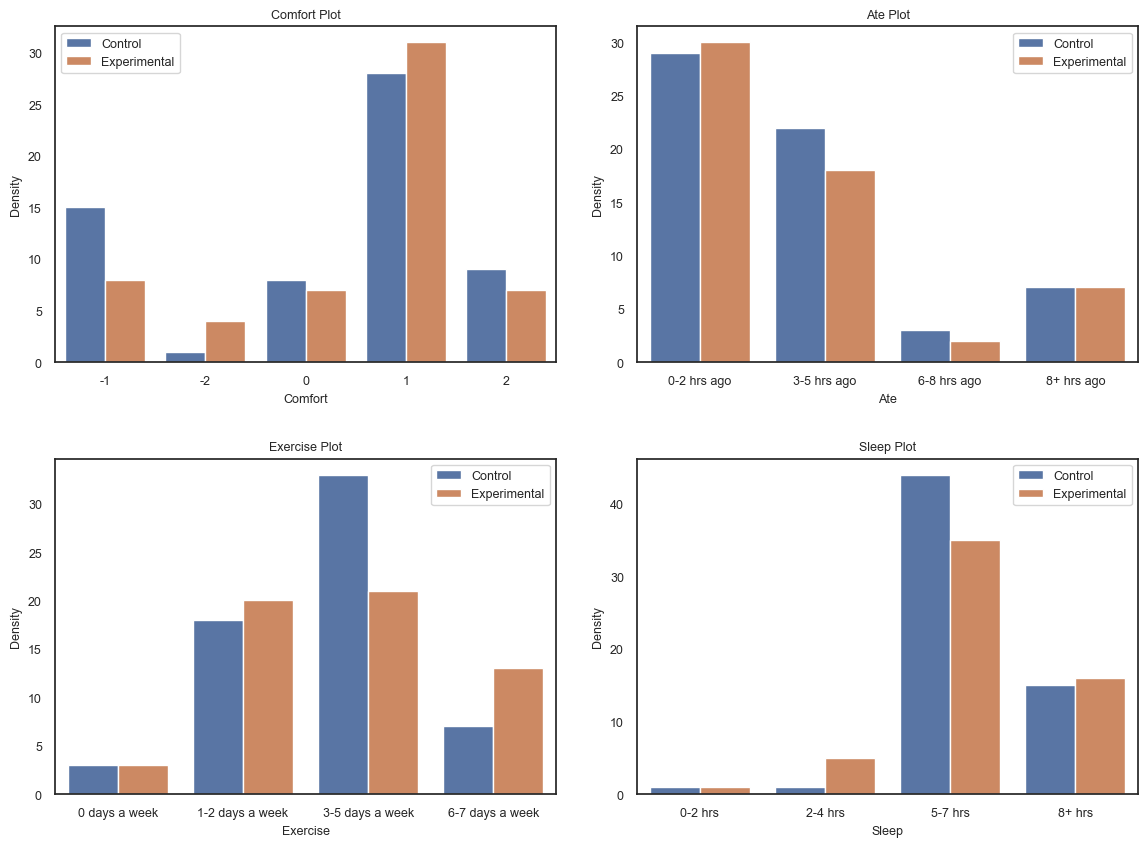

In [34]:
plot_bodystate(data, [2, 2], (12, 9))

In [35]:
def bodystate_relationships(data, subplots, fig_size):
    v, h = subplots[:2]
    fig, axes = plt.subplots(v, h, figsize=fig_size)
    label_size = 9
    i = 0

    if v * h == 1:
        axes = [axes]  # Convert single-axis to a list
    else:
        axes = axes.flatten()

    data2 = data.droplevel(level=0, axis=1)
    for x_col in data['Task'].columns:
        for y_col in data['Questions'].columns:
            sns.stripplot(data=data2, x=x_col, y=y_col, size=3, ax= axes[i], hue= "Group")
            axes[i].set_title(f"{x_col} vs. {y_col}", fontsize=label_size)
            axes[i].set_xlabel(x_col, fontsize=label_size)
            axes[i].set_ylabel(y_col, fontsize=label_size)
            axes[i].tick_params(axis="both", labelsize=label_size)
            axes[i].legend(fontsize= label_size)
            
            if x_col == "PageSubmit":
                axes[i].set_xlim(None, 750)
            i += 1

    if len(subplots) == 3:
        extra_axes = v * h - i
        for j in range(extra_axes):
            plt.delaxes(axes[i + j])
    plt.tight_layout()

Plot the relationships of bodystate to quitting time/score

***NOTE:** three outliers have been removed from all PageSubmit plots for ease of visualization*

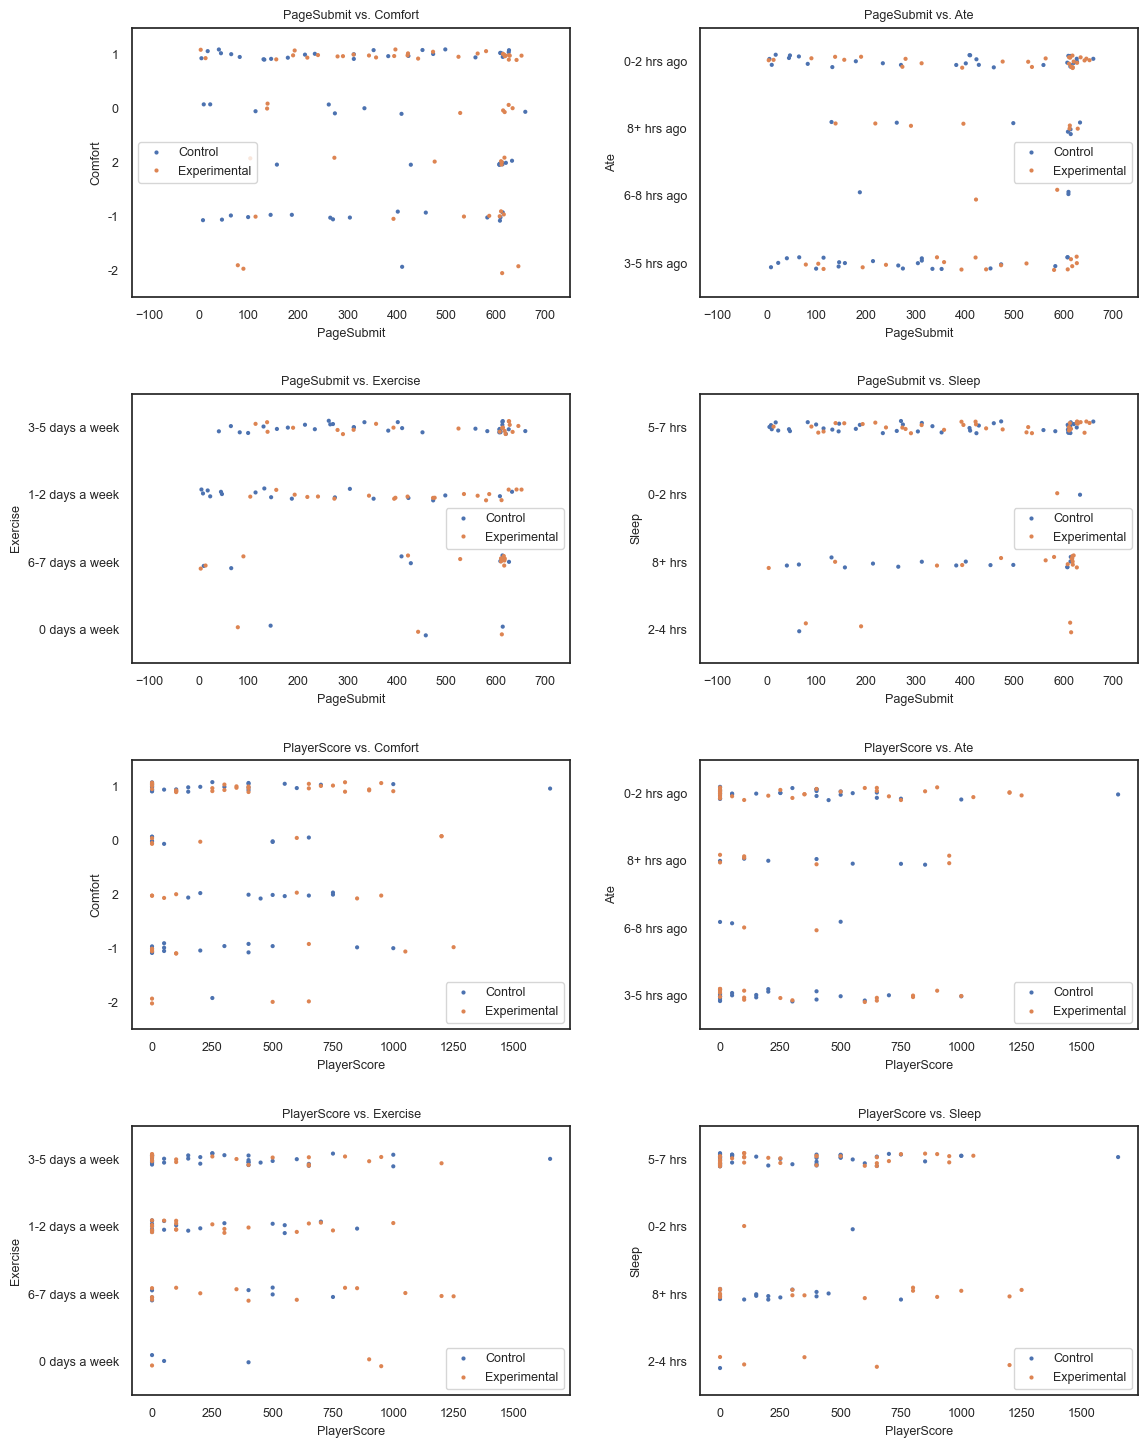

In [36]:
bodystate_relationships(data, [4, 2], [12, 15])

In [46]:
def bodystate_anova(data, y_col):
    anova_results = {}
    
    data2 = data.droplevel(level= 0, axis= 1)
    for x_col in data['Questions'].columns:
        formula = f'{y_col} ~ C({x_col}) + C(Group) + C({x_col}):C(Group)'
        model = ols(formula, data=data2).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results[x_col] = anova_table
    
    return anova_results

Generate and print ANOVAs: PlayerScore then PageSubmit

In [47]:
bs_score_anova = bodystate_anova(data, 'PlayerScore')
for key in bs_score_anova.keys():
    bs_score_anova[key] = pd.DataFrame(bs_score_anova[key])
    display(bs_score_anova[key])

,sum_sq,df,F,PR(>F)
C(Comfort),2.404404e+05,4.0,0.436711,0.781832
C(Group),2.775068e+05,1.0,2.016140,0.158515
C(Comfort):C(Group),2.898974e+05,4.0,0.526540,0.716439
Residual,1.486541e+07,108.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Ate),2.839513e+05,3.0,0.692987,0.558236
C(Group),2.162319e+05,1.0,1.583151,0.210972
C(Ate):C(Group),8.763858e+04,3.0,0.213883,0.886596
Residual,1.502415e+07,110.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Exercise),5.286314e+05,3.0,1.335243,0.266663
C(Group),2.202313e+05,1.0,1.668812,0.199125
C(Exercise):C(Group),3.505344e+05,3.0,0.885396,0.451129
Residual,1.451658e+07,110.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Sleep),1.613880e+04,3.0,0.039849,0.989331
C(Group),2.264977e+05,1.0,1.677745,0.197936
C(Sleep):C(Group),5.294661e+05,3.0,1.307312,0.275731
Residual,1.485014e+07,110.0,NaN,NaN


No p-values for the Two-Way ANOVA analysis between bodystate and PlayerScore indicated significance

In [49]:
bs_submit_anova = bodystate_anova(data, 'PageSubmit')
for key in bs_submit_anova.keys():
    bs_submit_anova[key] = pd.DataFrame(bs_submit_anova[key])
    display(bs_submit_anova[key])

,sum_sq,df,F,PR(>F)
C(Comfort),3.836376e+05,4.0,0.900023,0.466725
C(Group),5.927105e+05,1.0,5.562052,0.020153
C(Comfort):C(Group),8.390850e+05,4.0,1.968513,0.104447
Residual,1.150884e+07,108.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Ate),5.299721e+05,3.0,1.613539,0.190359
C(Group),4.363527e+05,1.0,3.985524,0.048363
C(Ate):C(Group),1.583035e+05,3.0,0.481967,0.695492
Residual,1.204328e+07,110.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Exercise),6.217935e+05,3.0,1.908240,0.132440
C(Group),4.718831e+05,1.0,4.344527,0.039443
C(Exercise):C(Group),1.620549e+05,3.0,0.497335,0.684886
Residual,1.194771e+07,110.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Sleep),5.700122e+05,3.0,1.798364,0.151706
C(Group),3.127363e+05,1.0,2.960009,0.088159
C(Sleep):C(Group),5.396250e+05,3.0,1.702494,0.170704
Residual,1.162192e+07,110.0,NaN,NaN


No interactions between bodystate and Group for PageSubmit

- p-values are significant for Group main effect on PageSubmit for all states except Sleep -- potentially caused by variability


# **Demographic Information**

In [ ]:
# Gender
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Gender"].value_counts(), labels= demographic_info["Q_Gender"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Gender", fontsize= labelsize)

In [ ]:
# Age
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Age"].value_counts(), labels= demographic_info["Q_Age"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Age", fontsize= labelsize)

In [ ]:
# Ethnicity
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Ethn"].value_counts(), labels= demographic_info["Q_Ethn"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Ethnicity", fontsize= labelsize)

In [ ]:
# Income
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Income"].value_counts(), labels= demographic_info["Q_Income"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Income", fontsize= labelsize)